# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [80]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

PCA shows dimensions (or combinations thereof) based on which help explain maximum variance. Looking at the data, we see that "Fresh" and "Grocery" have the top two std deviation. So The first dimension in PCA could be "Fresh" or a linear combination of "Fresh" with "Grocery" and some other dimensions which cover the maximum variability in the data. Same way, 2nd dimension could be another combination which is orthogonal to the first PCA Dimension. Also PCA dimensions are ordered (maximum first) based on the % variance explained by each dimension. 

ICA - selects dimensions based on maximization of Mutual Information and that the dimensions are statistically independent of each other. Going the variable names and applying practical context, we could say that one of the ICA dimension to be some linear combination of "Fresh", "Milk" and "Grocery". It could have some fraction of other input features also, however, the contribution from these three variables (Fresh, Milk and Grocery) to be more. Similarly, 2nd ICA dimension could ger largest contribution from "Detergents_paper" as based on the context, it is fair to assume that spending by consumers on "Detergents_paper" to be statistically independent of other spending and this should also be reflected in the data collected from stores who sell to the end customers. Following the same arguments, the 3rd ICA dimension could get significant contribution from "Delicatessen".

The other way to think about ICA is the blind source problem. We could look at the data coming from different types of customers/Stores (family run, high volume, speciality stores on "Delicatessen" etc) and getting mixed together in the given data. ICA will help us identify the underlying independent sources of signals (i.e. types of stores). It will achieve this by getting the axis of ICA roated features to align in the direction of types of stores that generated the data. The other way to say the same thing would be to consider ICA is an edge detector. In our cases edges will be the direction of the types of stores. 

### PCA

In [81]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

First PCA dimension explains about 46% of variance. 2nd PCA explains 40.5%. After these two PCA dimensions, we are left with 13.5% of variance and more than half of this (7%) is explained by 3rd PCA. 

So we have a choice of taking first two dimensions which together explain 86.5% of variance or taking first 3 PCA dimensions which together explain 93.5%. If we add fourth PCA then the four dimensions together explain 97.9% or almost 98%. 

I was tempted to choose 3 or 4 as a cut-off but then decided to settle for a cutoff of 2 PCA dimensions. This covers 86.5% of variance with a reasonable number of PCAs. A lower number of PCAs can help us have simpler interpretability of the model and will also make it easy to visualise in a 2-d plot. 

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

For PCA, since all factors are represented in same units (m.u.), there was no need to scale it. Some literature suggest that we should center the data before carrying out PCA and some do not insist. I tried both approaches and did not see any change in explained variance and/or pca compnents. Accordingly, decided to go with uncentered data for pca analysis.

First PCA dimension seems to be strongly correlated to spending on "Fresh" and it seems to be decreasing with increase in spending on "Fresh". As predicted in Q1, there seems to be some correlation between "Fresh" and "Milk" but it is a mild one since first PCA has factor of -0.97 for "Fresh" while only "-0.12" for Milk and -0.15 for "Frozen". Also as anticipated in Q1, the correlation of "Detergents_paper" seems to be lower with all other variables. So First PCA is roughly representative of spending on "Fresh". The stores high on this dimension are likely to get impacted more with the switching of delivery to evening bulk delivery.

I am using a correlation value of more than 0.50 (absolute value) as a cutoff for deciding if the impact/correlation is strong. 

Second PCA dimension is strongly correlated to "Milk" and "Grocery" wherein the second PCA is increasing with increase in "Milk" and "Grocery" spending. There also seems to be a correlation of 2nd PCA with "Detergents_Paper" spending, though not as strong as the relationship with "Milk" and "Grocery". Looking at this, we can also say that stores selling more "Milk" are likely to sell more "Grocery" and to an extent more "Detergents_Paper".

Just like 2nd pca, 3rd pca is strongly correlated to "Milk" and "Frozen". 3rd PCA increases with increase in spending on "Milk" and "Frozen". This also goes to show a fairly strong correlation between "Milk" and "Frozen".

Stores low on first PCA component and high on 2nd or 3rd component are less likely to see customer dissatisfaction due to switch in delivery from regular morning delivery to bulk evening delivery.


### ICA

In [82]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA(random_state=0)
ica.fit(data-data.mean())

# Print the independent components
print ica.components_*1e6

#print ica.mixing_
#data_ica= ica.transform(data-data.mean())
#data_back = ica.inverse_transform(data_ica)
#print data_back
#print (data-data.mean())

[[ -3.96476778   0.94532581   0.46685303   0.70740418  -1.60162442
    1.02573298]
 [  0.29520061  -1.04371945 -13.65079592   1.3224572   27.78005626
    5.37812672]
 [ -0.38835114  -0.31309014  -0.60514773  -0.53044696   0.44345299
   18.18002528]
 [ -0.22224356   6.98550165  -5.2719442   -0.76092071  -4.59784873
   -3.31640062]
 [ -0.33949319  -7.46323064   2.52138482   0.07619216  -4.01019796
    5.36150524]
 [ -0.86116521  -0.19483729   0.86814724  11.14873569  -0.60005015
   -5.93971213]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

For interpretting the ica components, I printed ICA components by multiplying the ica.components_ with "1e6" to have easy comprehension

[ -3.96476778   0.94532581   0.46685303   0.70740418  -1.60162442  1.02573298]

First component corresponds largely to first factor "Fresh" with a weight of -4.0e-6 with other factors having significantly lower weights. So first component indicates the axis of factor "Fresh". It could be more representative of smaller family run stores selling more of fresh stuff. 

[  0.29520061  -1.04371945 -13.65079592   1.3224572   27.78005626 5.37812672]

Second component is mostly getting contribution from "Detergents_Paper" (27.8e-6) and some -ve contribution from "Grocery" (-13.7e-6). The stores high on this axis in transformed data could be representative of high volume stores. 

[ -0.38835114  -0.31309014  -0.60514773  -0.53044696   0.44345299 18.18002528]

Third component is getting contribution mostly from "Delicatessen" (18.2e-6) and can be representative of stores focussing on delicacies.

[ -0.86116521  -0.19483729   0.86814724  11.14873569  -0.60005015 -5.93971213]

Sixth component is like 2nd component with maximum contribution from "Detergents_Paper" (11.1e-6) with some -ve contribution from "Delicatessen" (-6.0e-6). We can take this as also a rough representation of high volume stores. 

I found it tough to interpret 4th and 5th component which seem to have a mix of various factors. Both these could in general be taken as a factor of overall sale volume of a store.


## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

K Means clustering is a general purpose clustering algorithm which scales well for large data sets. K Means is also very easy to understand as it tries to cluster data around k centroids and has a very easy explanation. It is also supposed to be one of the best methods when the data is actually well separated into clusters. However the algorithm does not work well for non-linear data. For high dimensional data, it is advisable to apply dimensionality reduction using PCA before K Means is applied. in K Means clustering each data point is hard assigned to one cluster and then the centroid of each individual cluster is calculated based on the data points assigned. These clusters are then used to create regions in the data space for each cluster. 


Gaussian Mixture models assume that the underlying data is coming from a mix of Gaussian distributions with unknown data. In this case the assignment of each data point is soft. In other words each data point has some probability of belonging to each cluster. In other words the cluster assignment is soft (probabilistic). In fact we can say that Gaussian Mixture models are a special case of more generic Expectation Maximization algorithms and K Means is a special case of Gaussian Mixture where we move from soft assignment to hard assignment. 

(Ref: https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian)

Both the algorithms need "k" - the number of clusters to be fixed. I plan to use K Means to go with hard assignment of each data point to one (and only one cluster) as the purpose of this exercise is to identify underlying types of customers (stores) and clump them together into cluster to make some inferences. Using K Means will give us straight lines as boundaries which will be more relevant to identify the common theme in each cluster as opposed to using GMM which will give curved regions as boundaries. Curved regions will be harder to identify the common theme in each cluster.



**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [83]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [84]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca1 = PCA(n_components=2)
reduced_data = pca1.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [85]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
np.random.seed(1)
#clusters = GMM(n_components=4)
clusters = KMeans(n_clusters=4, random_state=1)
clusters.fit(reduced_data)
print clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)


In [86]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [87]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

#centroids = clusters.means_
centroids = clusters.cluster_centers_

print centroids

[[-23984.5576181   -4910.93673404]
 [  3496.78818727  -5024.80811368]
 [-14526.87614929  50607.64137279]
 [  6166.17305058  11736.81384052]]


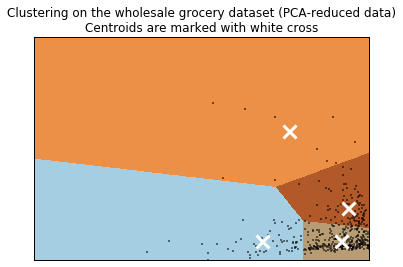

In [88]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Trying different numbers of clusters for K Means

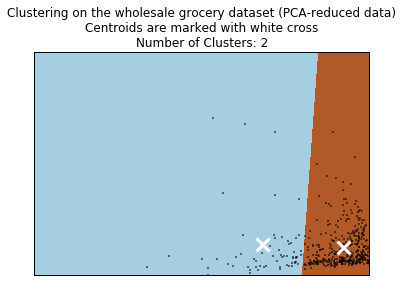

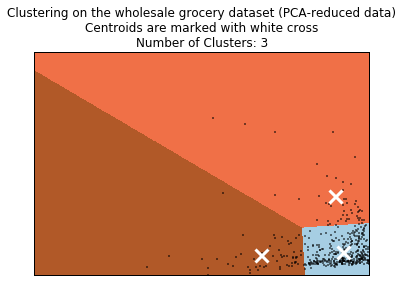

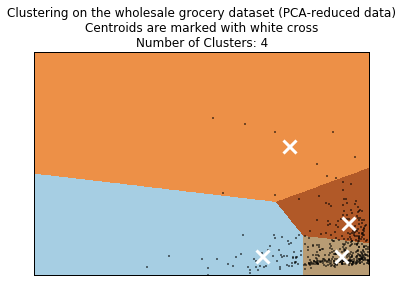

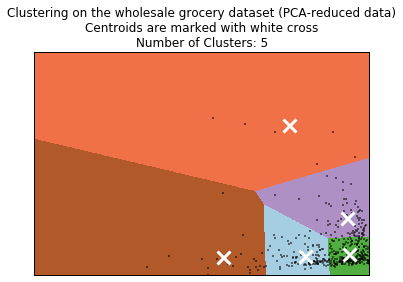

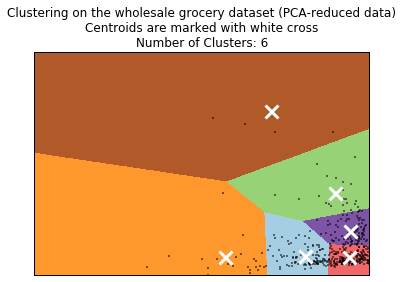

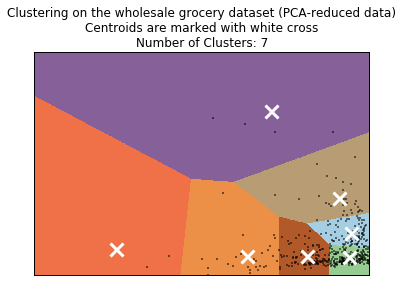

In [89]:
for n_clusters in range(2,8):

    clusters = KMeans(n_clusters=n_clusters, random_state=1)
    #clusters = GMM(n_components=n_clusters, random_state=1)
    clusters.fit(reduced_data)

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

    centroids = clusters.cluster_centers_
    #centroids = clusters.means_
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross\n'
              'Number of Clusters: {}'.format(n_clusters))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    

### Trying different numbers of clusters for GMM

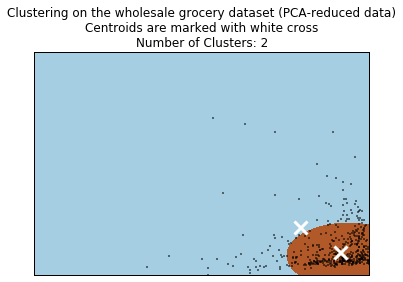

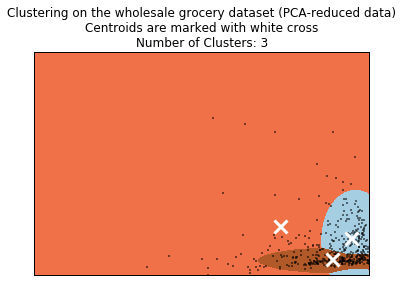

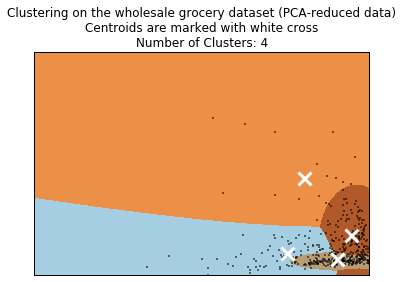

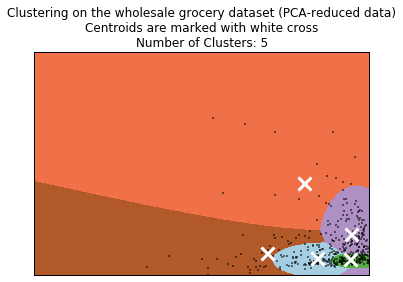

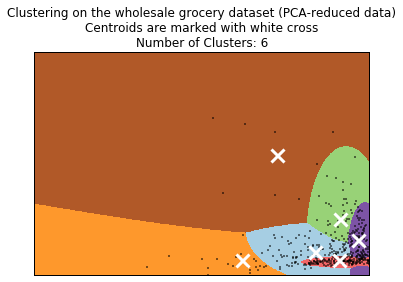

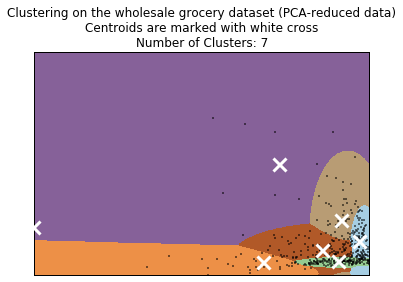

In [90]:
for n_clusters in range(2,8):

    #clusters = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = GMM(n_components=n_clusters, random_state=1)
    clusters.fit(reduced_data)

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

    #centroids = clusters.cluster_centers_
    centroids = clusters.means_
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross\n'
              'Number of Clusters: {}'.format(n_clusters))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

### Final Model: Clustering K Means with 3 clusters

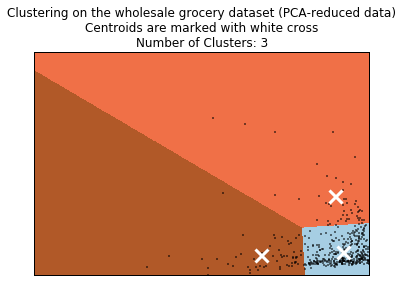

Centroids:
[[  4114.95375632  -3081.03219608]
 [  1339.44615464  25546.49074629]
 [-24220.71188261  -4364.45560022]]

Centroids in original 6 factor dimensions:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8323,3708,5342,2503,1785,1069
1,7866,18811,27402,2390,12224,2892
2,36135,6480,6105,6844,1116,2925



Total Sale at Centroids


0   22730
1   71585
2   59606
dtype: float64


Centroids product mix


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,37%,16%,24%,11%,8%,5%
1,11%,26%,38%,3%,17%,4%
2,61%,11%,10%,11%,2%,5%


In [91]:
n_clusters = 3
clusters = KMeans(n_clusters=n_clusters, random_state=1)
clusters.fit(reduced_data)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

centroids = clusters.cluster_centers_

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross\n'
          'Number of Clusters: {}'.format(n_clusters))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#interpret centroids in original dimensions after adding the mean back
from IPython.display import display, HTML

print "Centroids:"
print centroids
print

centroids_org = pd.DataFrame(pca1.inverse_transform(centroids), columns = list(data))
print "Centroids in original 6 factor dimensions:"
pd.options.display.float_format = '{:.0f}'.format
display(centroids_org)
print

print "Total Sale at Centroids"
display(centroids_org.sum(axis=1))
print

centroids_org_normalised = centroids_org.div(centroids_org.sum(axis=1), axis=0)*100
print "Centroids product mix"
pd.options.display.float_format = '{:.0f}%'.format
display(centroids_org_normalised)

pd.options.display.float_format = None


**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

I tried with various numbers of clusters, form 2 to 7. For each cluster size, I plotted the Voronoi diagrams both for K Means and GMM. As expected GMM gave non-linear boundaries making it hard to interpret and draw conclusions. K means gave linear boundaries. 

After studying the Voronoi diagrams for cluster number from 2 to 7, I settled for using cluster count of 3. The plot is shown above.

The first cluster is Blue one at the corner of bottom right. This corresponds to centroids[0] and has the following coordinates [  4114.95375632  -3081.03219608]. Looking at the sale volume table, the stores in cluster in general have lowest avg sale (22730 m.u.). Moving to product mix table, we see that stores in this cluster sell "fresh" as the largest category alongwith decent amount of grocery and milk. Going by the sale volume, these stores seem to indicate family run shops. Also this cluster represents the maximum number of customers (shops) for the wholesaler. They are likely to be impacted by the change in delivery from regular morning to bulk evening. However, as the analysis will show, the impact to these stores due this change in policy is lesser as compared to Cluster 3.

Second Cluster is Orange/Red one at the upper half of graph with centroid towards right middle. This corresponds to centroids[1] and has the following coordinates  [  1339.44615464  25546.49074629]. Looking at the sale volume table, the customers in this cluster in general have the highest avg annual sale (71585 m.u.). Their product mix has less of "fresh". Their highest selling category is Grocery followed by Milk and Detergents_Paper. These stores seem to indicate high volume customers. Also in this cluster there are few stores which are well spread out from its centroid and can indicate some very high volume customers. They are least likely to be impacted the change in delivery method. 

Third cluster is the brown one at the lower left+middle of the graph. This corresponds to centroids[2] and has the following coordinates [-24220.71188261  -4364.45560022]. They are the 2nd largest category in terms of total annual sale (71585 m.u.). These customers (stores) have a very high % of "fresh" in product mix. These seem to represent stores which are bigger than the smaller family run shops and look to be catering to nearby localities for the daily need of "Fresh". These customers are the most impact lot due to change in delivery policy of wholesaler.  


### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

I feel that PCA with K Means gave me lot of insights. Using PCA with 2 principal components help me identify the meaning of two components with first one representing "Fresh" and 2nd component representing a mix largly of other products esp "Milk", Grocery" and "Detergents_Paper". First two components of PCA explained 86.5% of the variance and pretty much captured most of the variation in data. Using just 2 components also helped visualize the data in simple compact plots.  

Armed with this, using K Means with three clusters on the reduced data set helped me create broad categories of stores and identify the characteristics of the stores in these clusters. As explained in detail above, PCA followed by K Means have provided a good way to segment the customers and identify their individual cluster characteristics. 

I felt that ICA decomposition for this problem was not very appropriate and did not offer very intuitive inferences. Also GMM with its non linear boundaries was not appropriate for this type of problem as with curved boundaries it was difficult to argue about common characteristics of each cluster. 


**9)** How would you use that technique to help the company design new experiments?

Answer: 

Armed with the three clusters and their defining features, I would use some form of A/B testing to test out any changes that the wholesaler in future would like to conduct. It can also be used to test introduction of new varieties e.g. organic fresh or it could also be used to try packings of different sizes esp smaller packings for non-perishable goods in Cluster 1 and 3. In an A/B testing setup, we will take sample customers from the clusters where we plan to make a change and then divide the sample into two sets. Each of the two set will be offered variations and then sale data could be studies to assess the effectiveness of the change before the same is introduced. 

Taking this approach from beginning would have helped the wholesaler to identify the impact of changing delivery to cheaper evening bulk delivery at each individual cluster level with a small sample. And based on the outcome of test setup, wholesaler could have adopted different delivery strategies for each cluster, thereby, optimizing its return on investment.  


**10)** How would you use that data to help you predict future customer needs?

Answer: 

Armed with the three clusters in 2 dimension PCA reduced data, we could label the stores in each cluster as three separate classes (aka "channels" in retail world) which require specific handling. The wholesaler may have different strategies for delivery, packaging, brands, product mix etc for each channel it is servicing. 

With the labelled data, we can now run KNN for creating a model to predict the class of a new customer. As and when the wholesaler starts servicing a new customer, it could use the prediction from KNN model to identify the class the new customer belongs to and then start offering the new customer most appropriate product mix, delivery and other policies designed for that channel. 

#### As suggsted by reviewer, trying some data transformation on PCA redced data to find better clusters

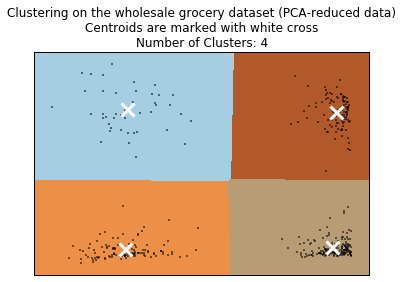

Centroids:
[[-5.83535216  6.04178913]
 [ 5.64973359 -5.49500695]
 [-5.9640281  -5.69877645]
 [ 5.82984373  5.86935139]]

Centroids in original 6 factor dimensions:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,17717,10769,14523,3952,5775,2445
1,6933,2515,3766,2289,1092,847
2,20034,3610,3820,4334,632,1696
3,4654,8573,12863,1915,5474,1464



Total Sale at Centroids


0   55181
1   17441
2   34126
3   34942
dtype: float64


Centroids product mix


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,32%,20%,26%,7%,10%,4%
1,40%,14%,22%,13%,6%,5%
2,59%,11%,11%,13%,2%,5%
3,13%,25%,37%,5%,16%,4%


In [92]:
# This was suggested by first reviewer. His graph showed some transformation which resulted in data being clubbed 
# into 4 very distinct clusters. I tried to recreate the transformation used by him

test_data = pd.DataFrame(reduced_data, columns=["a", "b"])
test_data.loc[:, "a1"] = test_data.loc[:, "a"].apply(lambda x: x**(1./5.) if 0<=x else -(-x)**(1./5.))
test_data.loc[:, "b1"] = test_data.loc[:, "b"].apply(lambda x: x**(1./5.) if 0<=x else -(-x)**(1./5.))

test_data.plot(kind="scatter", x="a1", y="b1")
reduced_data1 = test_data.loc[:,["a1", "b1"]].values

# Trying K Means clustering on this data with 4 clusters
n_clusters = 4
clusters = KMeans(n_clusters=n_clusters, random_state=1)
clusters.fit(reduced_data1)

x_min, x_max = reduced_data1[:, 0].min() - 1, reduced_data1[:, 0].max() + 1
y_min, y_max = reduced_data1[:, 1].min() - 1, reduced_data1[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

centroids = clusters.cluster_centers_

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data1[:, 0], reduced_data1[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross\n'
          'Number of Clusters: {}'.format(n_clusters))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#interpret centroids in original dimensions after adding the mean back
from IPython.display import display, HTML

print "Centroids:"
print centroids
print

centroids_xformed = [[x**5.0 for x in ls ] for ls in centroids]

centroids_org = pd.DataFrame(pca1.inverse_transform(centroids_xformed), columns = list(data))
print "Centroids in original 6 factor dimensions:"
pd.options.display.float_format = '{:.0f}'.format
display(centroids_org)
print

print "Total Sale at Centroids"
display(centroids_org.sum(axis=1))
print

centroids_org_normalised = centroids_org.div(centroids_org.sum(axis=1), axis=0)*100
print "Centroids product mix"
pd.options.display.float_format = '{:.0f}%'.format
display(centroids_org_normalised)

pd.options.display.float_format = None


Based on the Reviewer's suggestion, I can now see there are four clusters. The difference between CLuster 0 and Cluster 1 is more in terms of average sales volume though the product mix looks to be similar.

Cluster 2 and 3 in this plot are similar to cluster 1 and 2 in the analysis with 3 clusters. 

So it is really clutser 0 from (3 cluster analysis) which seems to have got split into 2 separate clusters.

In [93]:
print "DONE"

DONE
